<h3>Does precipitation level has anything to do with accident count?</h3>

`US_Accidents_Dec21_updated.csv` and `WeatherEvents_Jan2016-Dec2021.csv` are the main data.<br>
`US_Accidents_Dec21_updated.csv` - accident records for all the states.<br>
`WeatherEvents_Jan2016-Dec2021.csv` - weather events for all the states.<br><br>

Data of 5 cities from different states are extracted and combined.<br>
Producing 5 tables, `[City].csv`, which has **date** (2016-01-01 -> 2021-12-31) as row.<br><br>
>As cities are structured in different time period, `some data are lost`<br>
>Eg. Rain and Snow may happen in time 0000 -> 0600. however, only Rain is recorded

Used DataFrame:
1. `cities` (derived from original data)
2. `cities_cat` (only categorical columns,derived from `cities`)
3. `cities_week` (7 days of weather events into 1 row, derived from `cities`)
4. `data` (combination of all cities in `cities_week`)

In [2]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [3]:
names = ["Denver", "Miami", "Minneapolis", "New York", "Phoenix"]

# W[xxxx-yyyy] stands for weather type happened in [xxxx] -> [yyyy] on day something
# WS[X] stands for weather severity of the weather type happened in [xxxx] -> [yyyy]
# AS[xxxx-yyyy] stands for accident severity
# A_Total stands for total accident in a day 

category = ['W0000_0600','W0601_1200','W1201_1800','W1801_2359','WS1','WS2','WS3','WS4','AS0000_0600','AS0601_1200','AS1201_1800','AS1801_2359','Accident']
city_count = len(names)
cities = [ 
 pd.read_csv(names[0] + '.csv')
,pd.read_csv(names[1] + '.csv')
,pd.read_csv(names[2] + '.csv')
,pd.read_csv(names[3] + '.csv')
,pd.read_csv(names[4] + '.csv')
]
cities_cat = []
for i in range(city_count):
	cities_cat.append(cities[i][category].astype('category'))

In [4]:
cities_cat[0].describe()

,W0000_0600,W0601_1200,W1201_1800,W1801_2359,WS1,WS2,WS3,WS4,AS0000_0600,AS0601_1200,AS1201_1800,AS1801_2359,Accident
count,2192,2192,2192,2192,506,342,344,408,2192,2192,2192,2192,2192
unique,7,6,6,6,5,4,4,5,5,5,5,5,2
top,Clear,Clear,Clear,Clear,Light,Light,Light,Light,0,0,0,0,True
freq,1686,1850,1848,1784,394,236,156,304,1244,1165,1495,1929,1476


In [5]:
print("Weather type: ", cities_cat[0]['W0000_0600'].unique(), end ='\n\n')
print("Weather severity: ", cities_cat[0]['WS1'].unique(), end ='\n\n')
print("Accident severity: ", cities_cat[0]['AS0000_0600'].unique())
print("Dimension: ", cities[0].shape[0], "x", cities[0].shape[1])

Weather type:  ['Clear', 'Snow', 'Fog', 'Storm', 'Rain', 'Precipitation', 'Cold']
Categories (7, object): ['Clear', 'Cold', 'Fog', 'Precipitation', 'Rain', 'Snow', 'Storm']

Weather severity:  [NaN, 'Light', 'Moderate', 'Severe', 'UNK', 'Heavy']
Categories (5, object): ['Heavy', 'Light', 'Moderate', 'Severe', 'UNK']

Accident severity:  [0, 2, 3, 4, 1]
Categories (5, int64): [0, 1, 2, 3, 4]
Dimension:  2192 x 16


In [6]:
cities[0].corr() # this is just for the first city

,AS0000_0600,AS0601_1200,AS1201_1800,AS1801_2359,P_Value(in),A_Total,Accident
AS0000_0600,1.000000,0.419955,0.281306,0.074568,0.007494,0.472691,0.578661
AS0601_1200,0.419955,1.000000,0.342712,0.096925,-0.011970,0.480028,0.622771
AS1201_1800,0.281306,0.342712,1.000000,0.129609,-0.013796,0.479828,0.455465
AS1801_2359,0.074568,0.096925,0.129609,1.000000,0.000089,0.171389,0.247256
P_Value(in),0.007494,-0.011970,-0.013796,0.000089,1.000000,-0.005981,-0.046722
A_Total,0.472691,0.480028,0.479828,0.171389,-0.005981,1.000000,0.476280
Accident,0.578661,0.622771,0.455465,0.247256,-0.046722,0.476280,1.000000


Types of analysis:
   1. Correlation Matrix / Heatmap of `cities`
   2. Regression with random train-test split
   3. Attempt to use linear regression model on (`cities`, Response = `P_Value(in)`, Predictor =  `A_Total`)
   4. Attempt to use linear regression model on (`data`, Response = `A_Total`, Predictor = `Events`)
   5. Goodness of Fit of the Model

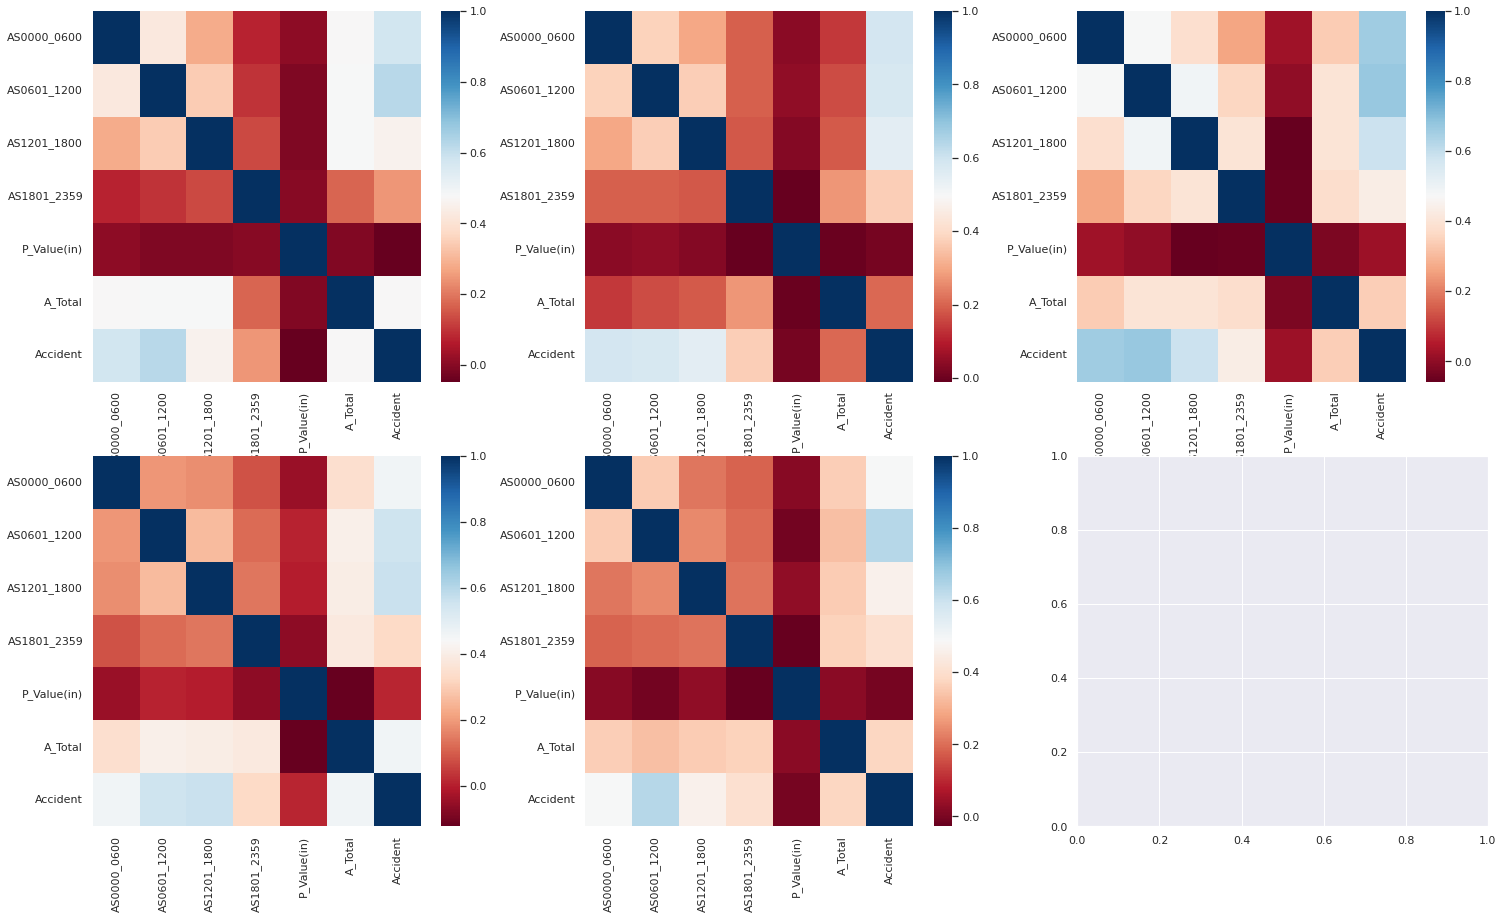

In [7]:
f, axes = plt.subplots(2, 3, figsize=(25, 15))

for i in range(5):  # correlation for all city
	sb.heatmap(cities[i].corr(), ax = axes[int(i/3),i%3], cmap = "RdBu")

It seems to be have no relationship between precipitation level `P_Value(in)` level and accident count `A_Total`.

<h3>Weather type vs Accident count</h3>

```Row order```: 1. Denver 2. Miami 3. Minneapolis 4. New York 5. Phoenix<br>
```Col order```: 1. 0000->0600 2. 0601->1200 3. 1201->1800 4. 1801->2359

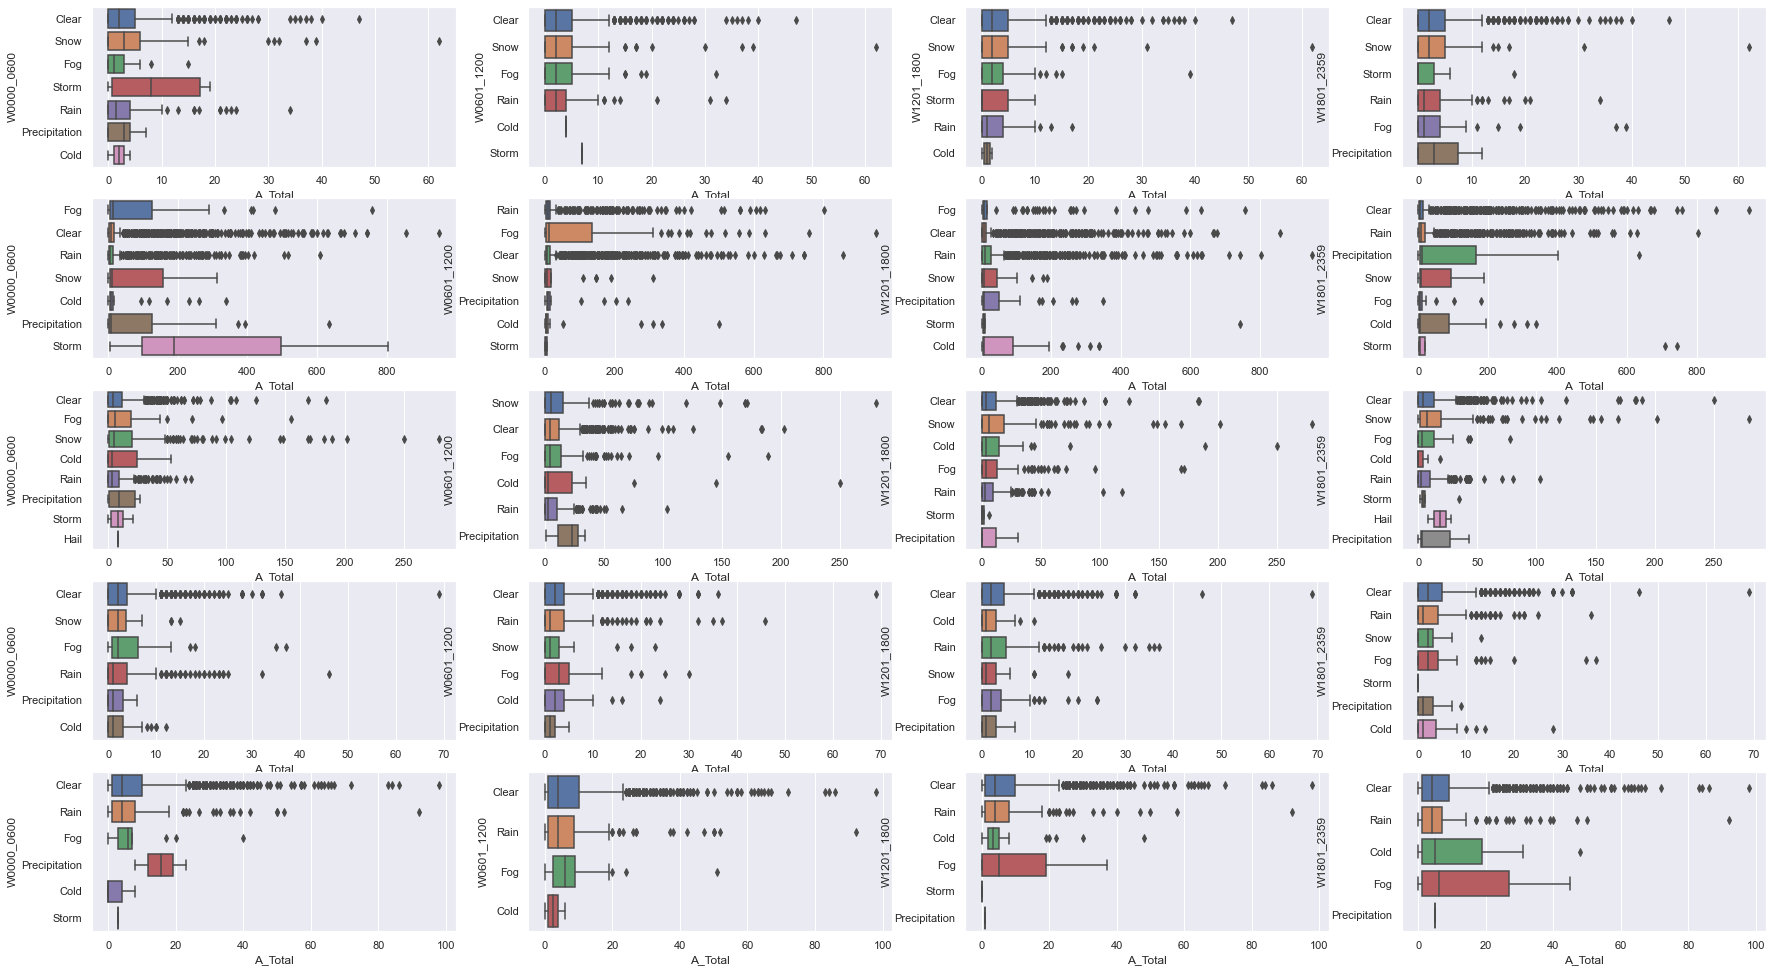

In [7]:
f, axes = plt.subplots(5, 4, figsize=(30, 17))
for i in range(city_count):
	for j in range(4):
		sb.boxplot(x = 'A_Total', y = category[j] , data = cities[i], orient = 'h', ax = axes[i,j])

<h3>Weather serverity vs Accident count</h3>

```Row order```: 1. Denver 2. Miami 3. Minneapolis 4. New York 5. Phoenix<br>
```Col order```: 1. 0000->0600 2. 0601->1200 3. 1201->1800 4. 1801->2359

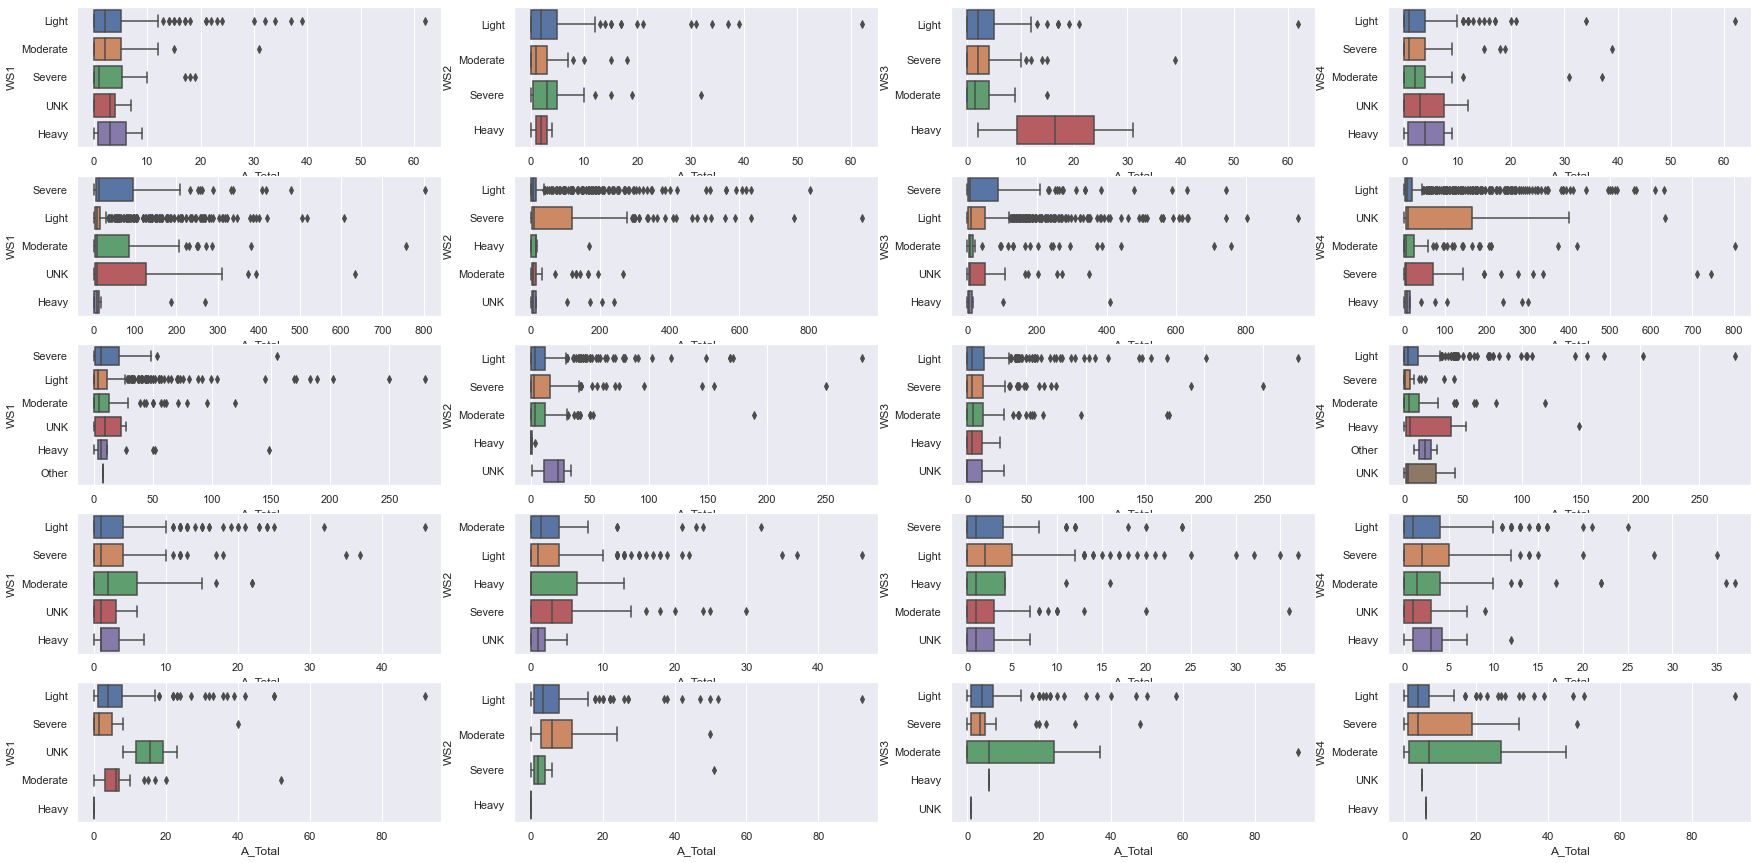

In [8]:
f, axes = plt.subplots(5, 4, figsize=(30, 15))
for i in range(city_count):
	for j in range(4):
		sb.boxplot(x = 'A_Total', y = category[j + 4] , data = cities[i], orient = 'h', ax = axes[i,j])

<h3>Getting week summary of weather events and accident count</h3>

1. New tables will be generated and stored in `cities_week`
2. Columns will be `weather types` and `A_total (in week)`
3. Calculating the weather events in 7 days
4. Eg. 1/1/2016 -> 1/7/2016 have 25 Clear and 3 Snow (for cities[0], ie. Denver)
5. Eg. 1/8/2016 -> 1/14/2016 have 20 Clear, 6 Snow and 2 Fog (for cities[0], ie. Denver)

In [8]:
row_init = cities[0].shape[0]
row_count = int(row_init / 7)
type_str = cities[0]['W0000_0600'].unique()
type_count = len(type_str)
col_order = type_str.tolist()

col_order.append("Events")
col_order.append("A_Total")
col_order.append("P_Value(in)")
cities_week = [[]] * city_count
for i in range(city_count):
	cities_week[i] = [[]] * row_count

print("Col order:", col_order)
# this part sums up the records every 7 days
for i in range(city_count):
	accumulate = [0 for i in range(type_count + 3)]
	for j in range(row_init):
		if j%7 == 0 and j != 0:
			for k in range(1, type_count):
				accumulate[type_count] = accumulate[type_count] + accumulate[k]
			cities_week[i][int(j/7)-1] = accumulate
			accumulate = [0 for i in range(type_count + 3)]
		for k in range(type_count):
			for c in range(4): # category 0, 1, 2, 3
				if cities[i][category[c]][j] == type_str[k]:
					accumulate[k] = accumulate[k] + 1
		accumulate[type_count + 1] = accumulate[type_count + 1] + cities[i]['A_Total'][j]
		accumulate[type_count + 2] = accumulate[type_count + 2] + cities[i]['P_Value(in)'][j]

print("Captured: ", len(cities_week), "cities,", len(cities_week[0]), "rows,", len(cities_week[0][312]), "columns")
for i in range(city_count):
	cities_week[i] = pd.DataFrame.from_records(cities_week[i], columns=col_order)


Col order: ['Clear', 'Snow', 'Fog', 'Storm', 'Rain', 'Precipitation', 'Cold', 'Events', 'A_Total', 'P_Value(in)']
Captured:  5 cities, 313 rows, 10 columns


In [10]:
# Calculating the weather events in 7 days
# Eg. 1/1/2016 -> 1/7/2016 have 25 Clear and 3 Snow
# Eg. 1/8/2016 -> 1/14/2016 have 20 Clear, 6 Snow and 2 Fog
cities[0].head(14)

,Date,W0000_0600,W0601_1200,W1201_1800,W1801_2359,WS1,WS2,WS3,WS4,AS0000_0600,AS0601_1200,AS1201_1800,AS1801_2359,P_Value(in),A_Total,Accident
0,1/1/2016,Clear,Clear,Clear,Clear,NaN,NaN,NaN,NaN,0,0,0,0,0.00,0,False
1,1/2/2016,Clear,Clear,Clear,Clear,NaN,NaN,NaN,NaN,0,0,0,0,0.00,0,False
2,1/3/2016,Clear,Clear,Clear,Clear,NaN,NaN,NaN,NaN,0,0,0,0,0.00,0,False
3,1/4/2016,Clear,Clear,Clear,Clear,NaN,NaN,NaN,NaN,0,0,0,0,0.00,0,False
4,1/5/2016,Clear,Clear,Clear,Clear,NaN,NaN,NaN,NaN,0,0,0,0,0.00,0,False
5,1/6/2016,Clear,Clear,Clear,Clear,NaN,NaN,NaN,NaN,0,0,0,0,0.00,0,False
6,1/7/2016,Clear,Snow,Snow,Snow,NaN,Light,Light,Light,0,0,0,0,0.39,0,False
7,1/8/2016,Clear,Snow,Snow,Snow,NaN,Moderate,Light,Light,0,0,0,0,0.30,0,False
8,1/9/2016,Snow,Clear,Clear,Snow,Light,NaN,NaN,Light,0,0,0,0,0.01,0,False
9,1/10/2016,Clear,Fog,Snow,Clear,NaN,Severe,Light,NaN,0,0,0,0,0.00,0,False


In [11]:
cities_week[0].head(2) # summary of first 7 days from cities[0]

,Clear,Snow,Fog,Storm,Rain,Precipitation,Cold,Events,A_Total,P_Value(in)
0,25,3,0,0,0,0,0,3,0,0.39
1,20,6,2,0,0,0,0,8,0,0.31


In [12]:
cities_week[1].corr() # unfortunately, there are still no relations between weather and accident count

,Clear,Snow,Fog,Storm,Rain,Precipitation,Cold,Events,A_Total,P_Value(in)
Clear,1.000000,-0.010711,-0.070770,0.032004,-0.896279,-0.249017,-0.153613,-1.000000,-0.072154,-0.522621
Snow,-0.010711,1.000000,0.123985,-0.046715,-0.149684,-0.091996,-0.104073,0.010711,0.017030,-0.107933
Fog,-0.070770,0.123985,1.000000,-0.010263,-0.249914,-0.035288,-0.082596,0.070770,0.192506,-0.184582
Storm,0.032004,-0.046715,-0.010263,1.000000,-0.094803,-0.091111,0.126901,-0.032004,0.160381,-0.103301
Rain,-0.896279,-0.149684,-0.249914,-0.094803,1.000000,0.131329,-0.058250,0.896279,-0.038443,0.540507
Precipitation,-0.249017,-0.091996,-0.035288,-0.091111,0.131329,1.000000,-0.036734,0.249017,0.126519,0.461952
Cold,-0.153613,-0.104073,-0.082596,0.126901,-0.058250,-0.036734,1.000000,0.153613,0.061471,-0.032318
Events,-1.000000,0.010711,0.070770,-0.032004,0.896279,0.249017,0.153613,1.000000,0.072154,0.522621
A_Total,-0.072154,0.017030,0.192506,0.160381,-0.038443,0.126519,0.061471,0.072154,1.000000,-0.046126
P_Value(in),-0.522621,-0.107933,-0.184582,-0.103301,0.540507,0.461952,-0.032318,0.522621,-0.046126,1.000000


In [13]:
for i in range(city_count): # correlation
	print(names[i], "Events vs P_Value(in):", cities_week[i]['Events'].corr(cities_week[i]['P_Value(in)']))

Denver Events vs P_Value(in): 0.5235110937010011
Miami Events vs P_Value(in): 0.5226207378219824
Minneapolis Events vs P_Value(in): 0.18010834405722287
New York Events vs P_Value(in): 0.6720759810845754
Phoenix Events vs P_Value(in): 0.5992968181630985


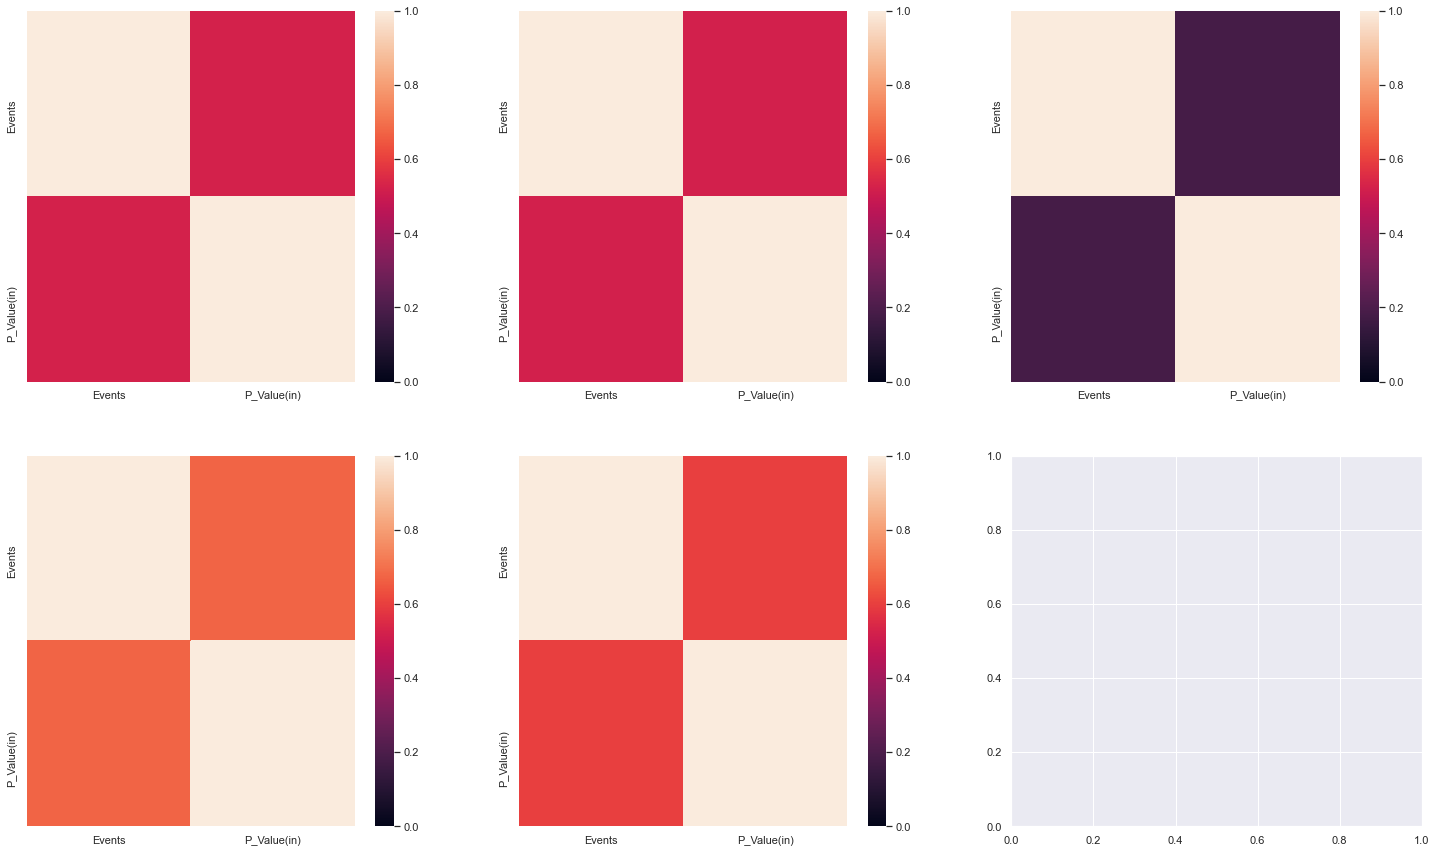

In [14]:
f, axes = plt.subplots(2, 3, figsize=(25, 15)) # relations between weather count and for all cities

for i in range(city_count):
	sb.heatmap(cities_week[i][['Events', 'P_Value(in)']].corr(), ax = axes[int(i/3),i%3], vmin=0, vmax=1)

<h3>Attempt to predict A_Total using Events (Linear Regression)</h3>

1. New dataframe [```data```] is produced to simplify visualisations
2. From the correlation matrix, it seems like weather type has nothing much to do with accidents
3. ```Clear``` weather are excluded in Events
4. ```Events``` are the ```combination of Snow, Fog, Storm, Rain, Precipitation & Cold```
5. Correlation between ```A_Total``` and ```Events``` is barely ```0.163630```
6. The expected linear regression model will be bad (still, need to find it out first)

In [15]:
# Combine all the 5 cities together to produce data
data = pd.concat([cities_week[0], cities_week[1], cities_week[2], cities_week[3], cities_week[4]],axis=0, ignore_index=True)
data.head()

,Clear,Snow,Fog,Storm,Rain,Precipitation,Cold,Events,A_Total,P_Value(in)
0,25,3,0,0,0,0,0,3,0,0.39
1,20,6,2,0,0,0,0,8,0,0.31
2,23,4,1,0,0,0,0,5,0,0.05
3,26,2,0,0,0,0,0,2,0,0.00
4,18,10,0,0,0,0,0,10,0,0.92


In [16]:
# 5 cities are combined to produce data
data.corr()

,Clear,Snow,Fog,Storm,Rain,Precipitation,Cold,Events,A_Total,P_Value(in)
Clear,1.000000,-0.275718,-0.354527,0.003860,-0.718699,-0.329289,-0.216972,-0.999949,-0.163569,-0.303375
Snow,-0.275718,1.000000,0.158044,-0.022579,-0.237776,-0.077727,0.031433,0.274753,-0.020868,-0.047462
Fog,-0.354527,0.158044,1.000000,-0.002504,-0.042038,-0.020070,-0.015144,0.354737,0.080251,-0.021608
Storm,0.003860,-0.022579,-0.002504,1.000000,-0.025017,-0.046054,0.011523,-0.003802,0.097099,-0.039101
Rain,-0.718699,-0.237776,-0.042038,-0.025017,1.000000,0.019028,0.015661,0.719101,0.161940,0.010389
Precipitation,-0.329289,-0.077727,-0.020070,-0.046054,0.019028,1.000000,-0.037584,0.329500,-0.012329,0.909098
Cold,-0.216972,0.031433,-0.015144,0.011523,0.015661,-0.037584,1.000000,0.216954,0.060053,-0.031977
Events,-0.999949,0.274753,0.354737,-0.003802,0.719101,0.329500,0.216954,1.000000,0.163630,0.303545
A_Total,-0.163569,-0.020868,0.080251,0.097099,0.161940,-0.012329,0.060053,0.163630,1.000000,-0.058949
P_Value(in),-0.303375,-0.047462,-0.021608,-0.039101,0.010389,0.909098,-0.031977,0.303545,-0.058949,1.000000


In [17]:
# Fitting some model here
lr = LinearRegression()

y = pd.DataFrame(data['A_Total'])
X = pd.DataFrame(data['Events'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
lr.fit(X_train, y_train)

print('Intercept \t: b = ', lr.intercept_)
print('Coefficients \t: a = ', lr.coef_)

lx = X_train
ly = lr.intercept_ + lr.coef_ * X_train

Intercept 	: b =  [29.71180796]
Coefficients 	: a =  [[10.82574488]]


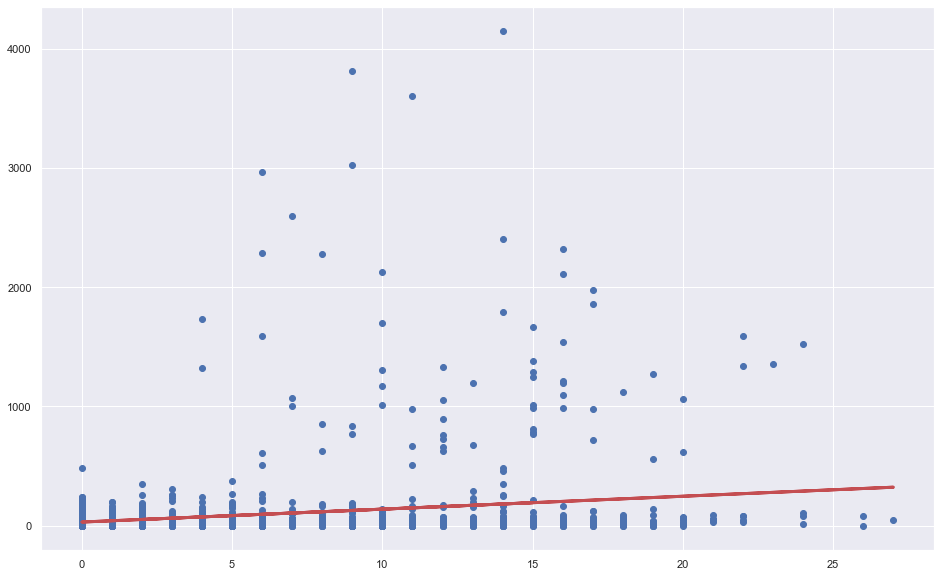

Explained Variance (R^2) : 0.02833530694576858


In [18]:
f, axes = plt.subplots(1, 1, figsize=(16, 10))

plt.scatter(X_train, y_train)
plt.plot(lx.to_numpy(), ly.to_numpy(), 'r-', linewidth = 3)
plt.show()

print("Explained Variance (R^2) :", lr.score(X_train, y_train))

>As expected, the explained Variance (R^2) for the linear regression model is ```extremly bad```

<h3>Classifcation Tree to predict whether weather cause accident</h3>

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.6715328467153284
Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.6806569343065694

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.8412408759124088
Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.791970802919708

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.6934306569343066
Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.7244525547445255

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.6587591240875912
Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.6605839416058394

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.7901459854014599
Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.7463503649635036



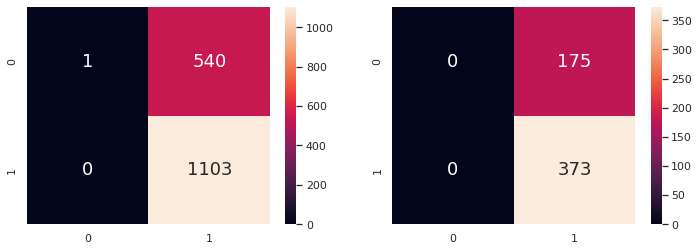

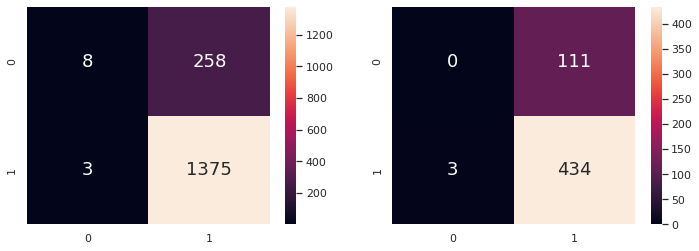

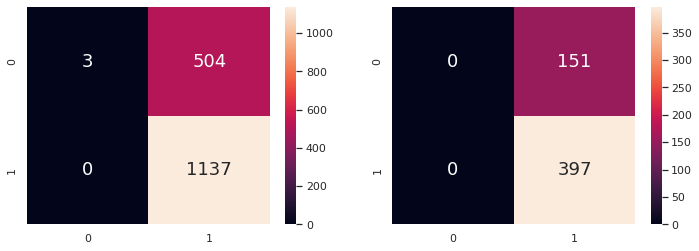

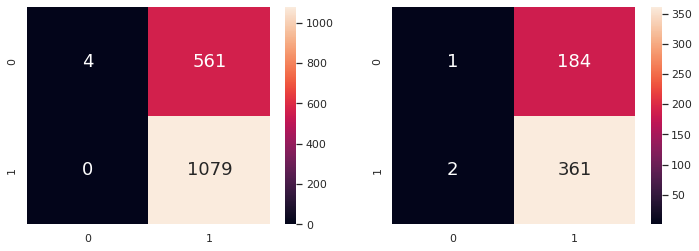

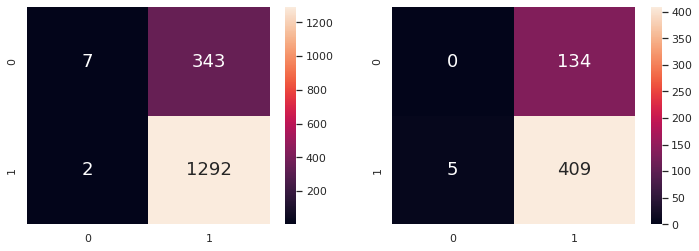

In [11]:
# Import essential models and functions from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

for i in range(city_count):
	accident = pd.DataFrame(cities[i]['Accident'])  # Response
	p_val = pd.DataFrame(cities[i]['P_Value(in)'])  # Predictor
	X_train, X_test, y_train, y_test = train_test_split(p_val, accident, test_size = 0.25)
	dectree = DecisionTreeClassifier(max_depth = 4)  # create the decision tree object
	dectree.fit(X_train, y_train)  # train the decision tree model
	y_train_pred = dectree.predict(X_train)
	y_test_pred = dectree.predict(X_test)
	print("Goodness of Fit of Model \tTrain Dataset") # Check the Goodness of Fit (on Train Data)
	print("Classification Accuracy \t:", dectree.score(X_train, y_train))
	print("Goodness of Fit of Model \tTest Dataset") # Check the Goodness of Fit (on Test Data)
	print("Classification Accuracy \t:", dectree.score(X_test, y_test), end ="\n\n")
	f, axes = plt.subplots(1, 2, figsize=(12, 4)) # Plot the Confusion Matrix for Train and Test
	sb.heatmap(confusion_matrix(y_train, y_train_pred), annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
	sb.heatmap(confusion_matrix(y_test, y_test_pred), annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])


Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.6891727493917275
Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.6313868613138686

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.8260340632603407
Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.833941605839416

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.7074209245742092
Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.6861313868613139

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.6593673965936739
Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.6551094890510949

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.7901459854014599
Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.7481751824817519



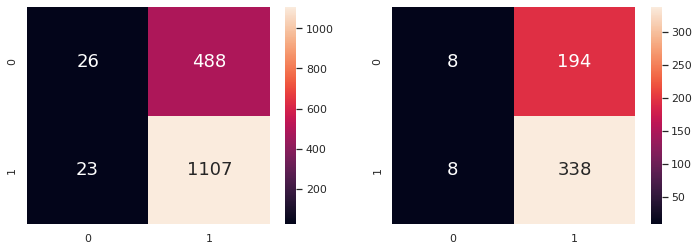

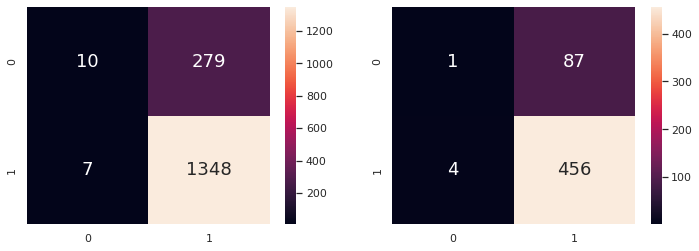

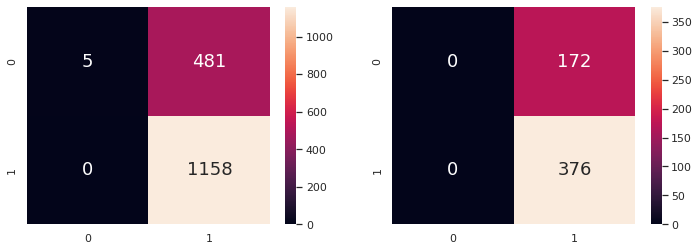

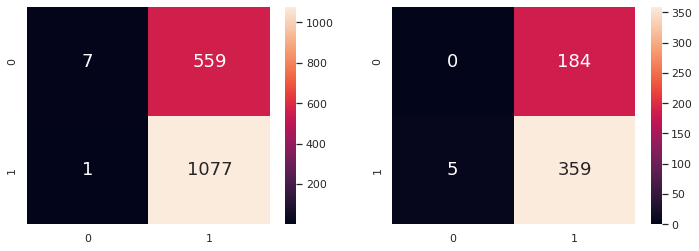

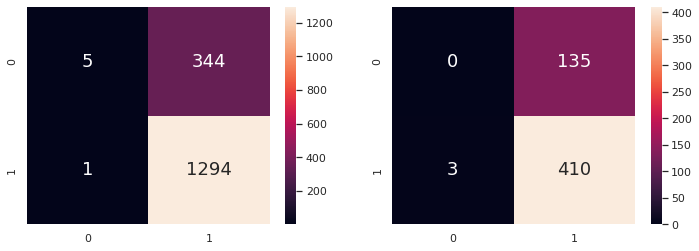

In [12]:
# Import essential models and functions from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

for i in range(city_count):
	accident = pd.DataFrame(cities[i]['Accident'])  # Response
	p_val = pd.DataFrame(cities[i]['P_Value(in)'])  # Predictor
	X_train, X_test, y_train, y_test = train_test_split(p_val, accident, test_size = 0.25)
	dectree = DecisionTreeClassifier(max_depth = 4)
	dectree.fit(X_train, y_train)  # train the decision tree model
	y_train_pred = dectree.predict(X_train)
	y_test_pred = dectree.predict(X_test)
	print("Goodness of Fit of Model \tTrain Dataset") # Check the Goodness of Fit (on Train Data)
	print("Classification Accuracy \t:", dectree.score(X_train, y_train))
	print("Goodness of Fit of Model \tTest Dataset") # Check the Goodness of Fit (on Test Data)
	print("Classification Accuracy \t:", dectree.score(X_test, y_test), end ="\n\n")
	f, axes = plt.subplots(1, 2, figsize=(12, 4)) # Plot the Confusion Matrix for Train and Test
	sb.heatmap(confusion_matrix(y_train, y_train_pred), annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
	sb.heatmap(confusion_matrix(y_test, y_test_pred), annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])


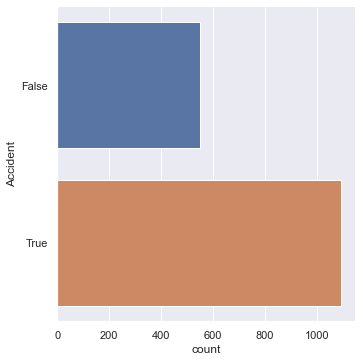

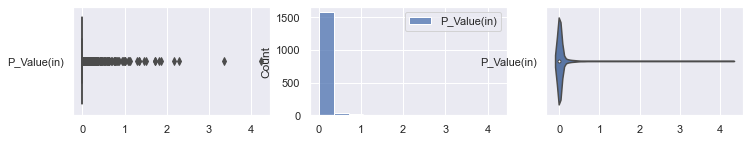

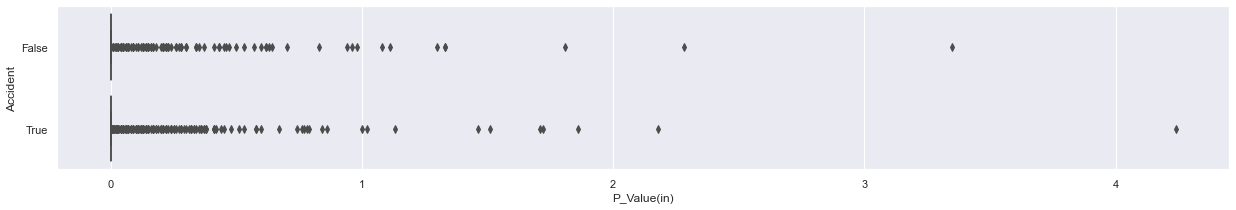

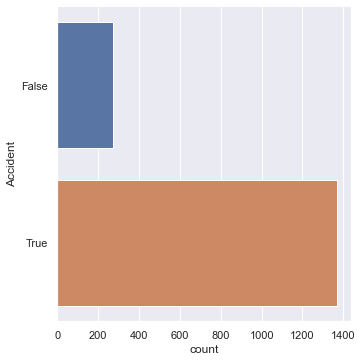

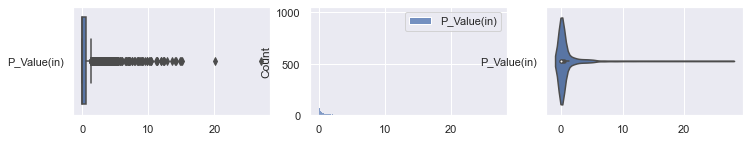

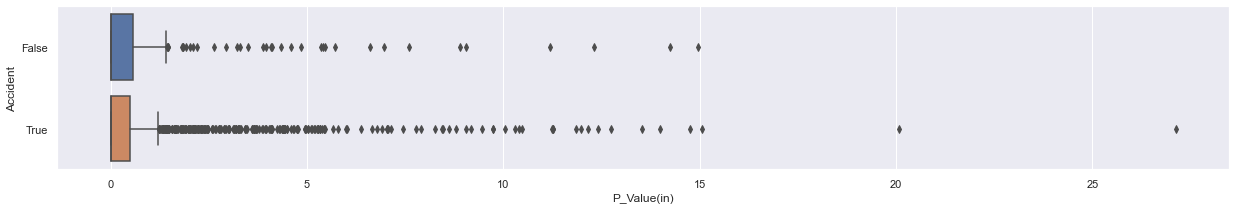

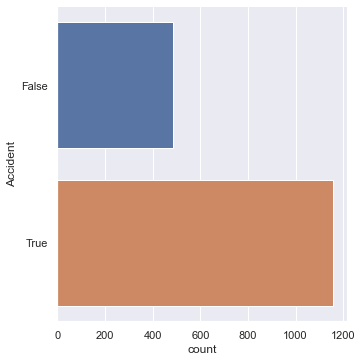

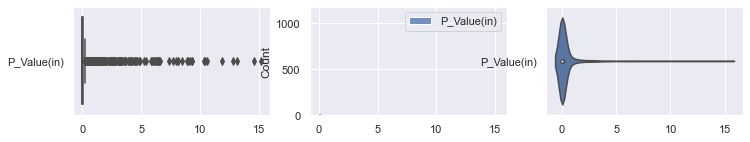

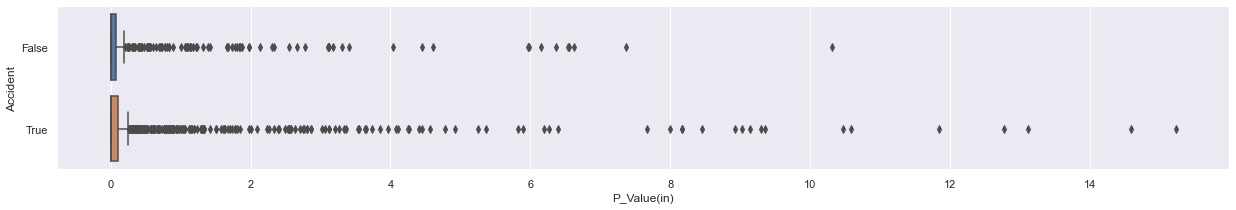

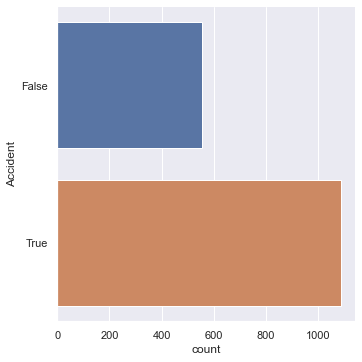

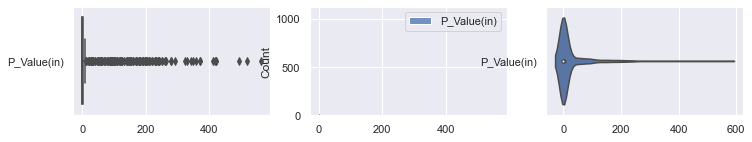

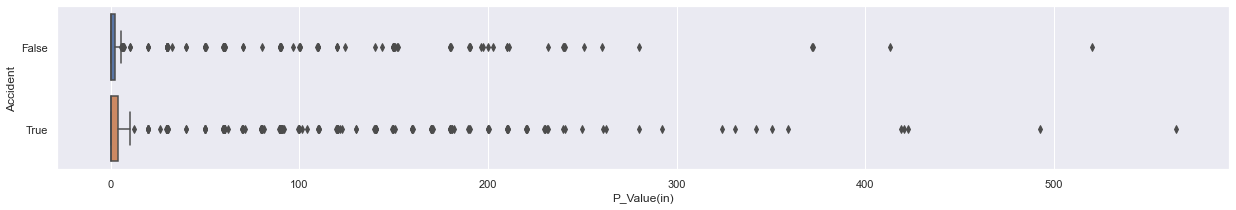

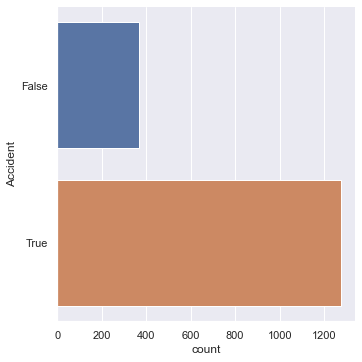

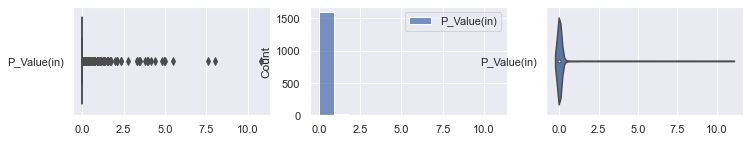

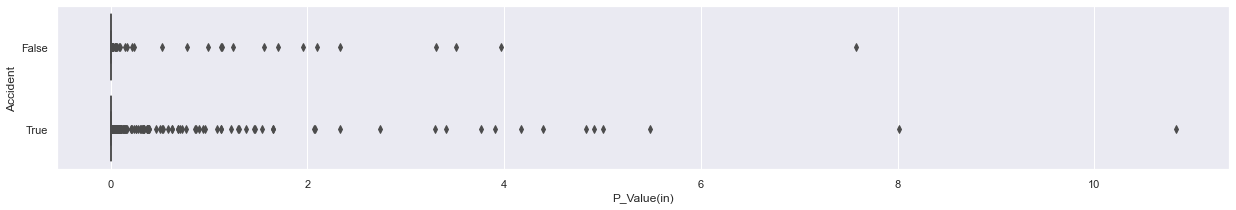

In [21]:
for i in range(city_count):
	accident = pd.DataFrame(cities[i]['Accident'])  # Response
	p_val = pd.DataFrame(cities[i]['P_Value(in)'])  # Predictor
	X_train, X_test, y_train, y_test = train_test_split(p_val, accident, test_size = 0.25)
	sb.catplot(y = "Accident", data = y_train, kind = "count")
	f, axes = plt.subplots(1, 3, figsize=(12, 2))
	sb.boxplot(data = X_train, orient = "h", ax = axes[0])
	sb.histplot(data = X_train, ax = axes[1])
	sb.violinplot(data = X_train, orient = "h", ax = axes[2])
	trainDF = pd.concat([X_train, y_train], axis = 1).reindex(X_train.index)
	f = plt.figure(figsize=(21, 3))
	sb.boxplot(x = "P_Value(in)", y = "Accident", data = trainDF, orient = "h")


<h3>Classifcation Tree to predict whether weather cause accident</h3>

Combined cities

In [13]:
# join plot between P_Value(in) and Accident(T/F) for all cities
data2 = pd.concat([cities[0], cities[1], cities[2], cities[3], cities[4]],axis=0, ignore_index=True)

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.7298053527980535

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.7211678832116788


<AxesSubplot:>

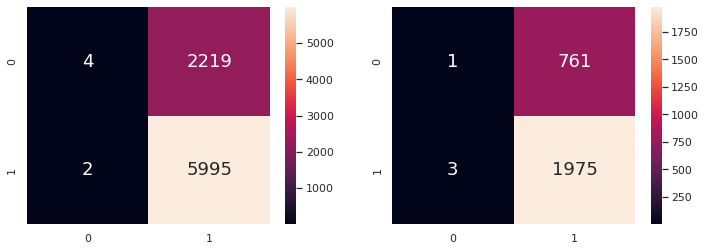

In [41]:
# Import essential models and functions from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

accident = pd.DataFrame(data2['Accident'])  # Response
p_val = pd.DataFrame(data2['P_Value(in)'])  # Predictor
X_train, X_test, y_train, y_test = train_test_split(p_val, accident, test_size = 0.25)
dectree = DecisionTreeClassifier(max_depth = 2)  # create the decision tree object
dectree.fit(X_train, y_train)  # train the decision tree model
y_train_pred = dectree.predict(X_train)
y_test_pred = dectree.predict(X_test)
print("Goodness of Fit of Model \tTrain Dataset") # Check the Goodness of Fit (on Train Data)
print("Classification Accuracy \t:", dectree.score(X_train, y_train))
print()
print("Goodness of Fit of Model \tTest Dataset") # Check the Goodness of Fit (on Test Data)
print("Classification Accuracy \t:", dectree.score(X_test, y_test))
f, axes = plt.subplots(1, 2, figsize=(12, 4)) # Plot the Confusion Matrix for Train and Test
sb.heatmap(confusion_matrix(y_train, y_train_pred), annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(confusion_matrix(y_test, y_test_pred), annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])


[Text(669.6, 1087.2, 'P_Value(in) <= 29.955\ngini = 0.398\nsamples = 8220\nvalue = [2251, 5969]\nclass = Accident'),
 Text(334.8, 652.32, 'P_Value(in) <= 3.405\ngini = 0.395\nsamples = 7887\nvalue = [2135, 5752]\nclass = Accident'),
 Text(167.4, 217.44000000000005, 'gini = 0.397\nsamples = 7623\nvalue = [2084, 5539]\nclass = Accident'),
 Text(502.20000000000005, 217.44000000000005, 'gini = 0.312\nsamples = 264\nvalue = [51, 213]\nclass = Accident'),
 Text(1004.4000000000001, 652.32, 'P_Value(in) <= 61.295\ngini = 0.454\nsamples = 333\nvalue = [116, 217]\nclass = Accident'),
 Text(837.0, 217.44000000000005, 'gini = 0.482\nsamples = 126\nvalue = [51, 75]\nclass = Accident'),
 Text(1171.8, 217.44000000000005, 'gini = 0.431\nsamples = 207\nvalue = [65, 142]\nclass = Accident')]

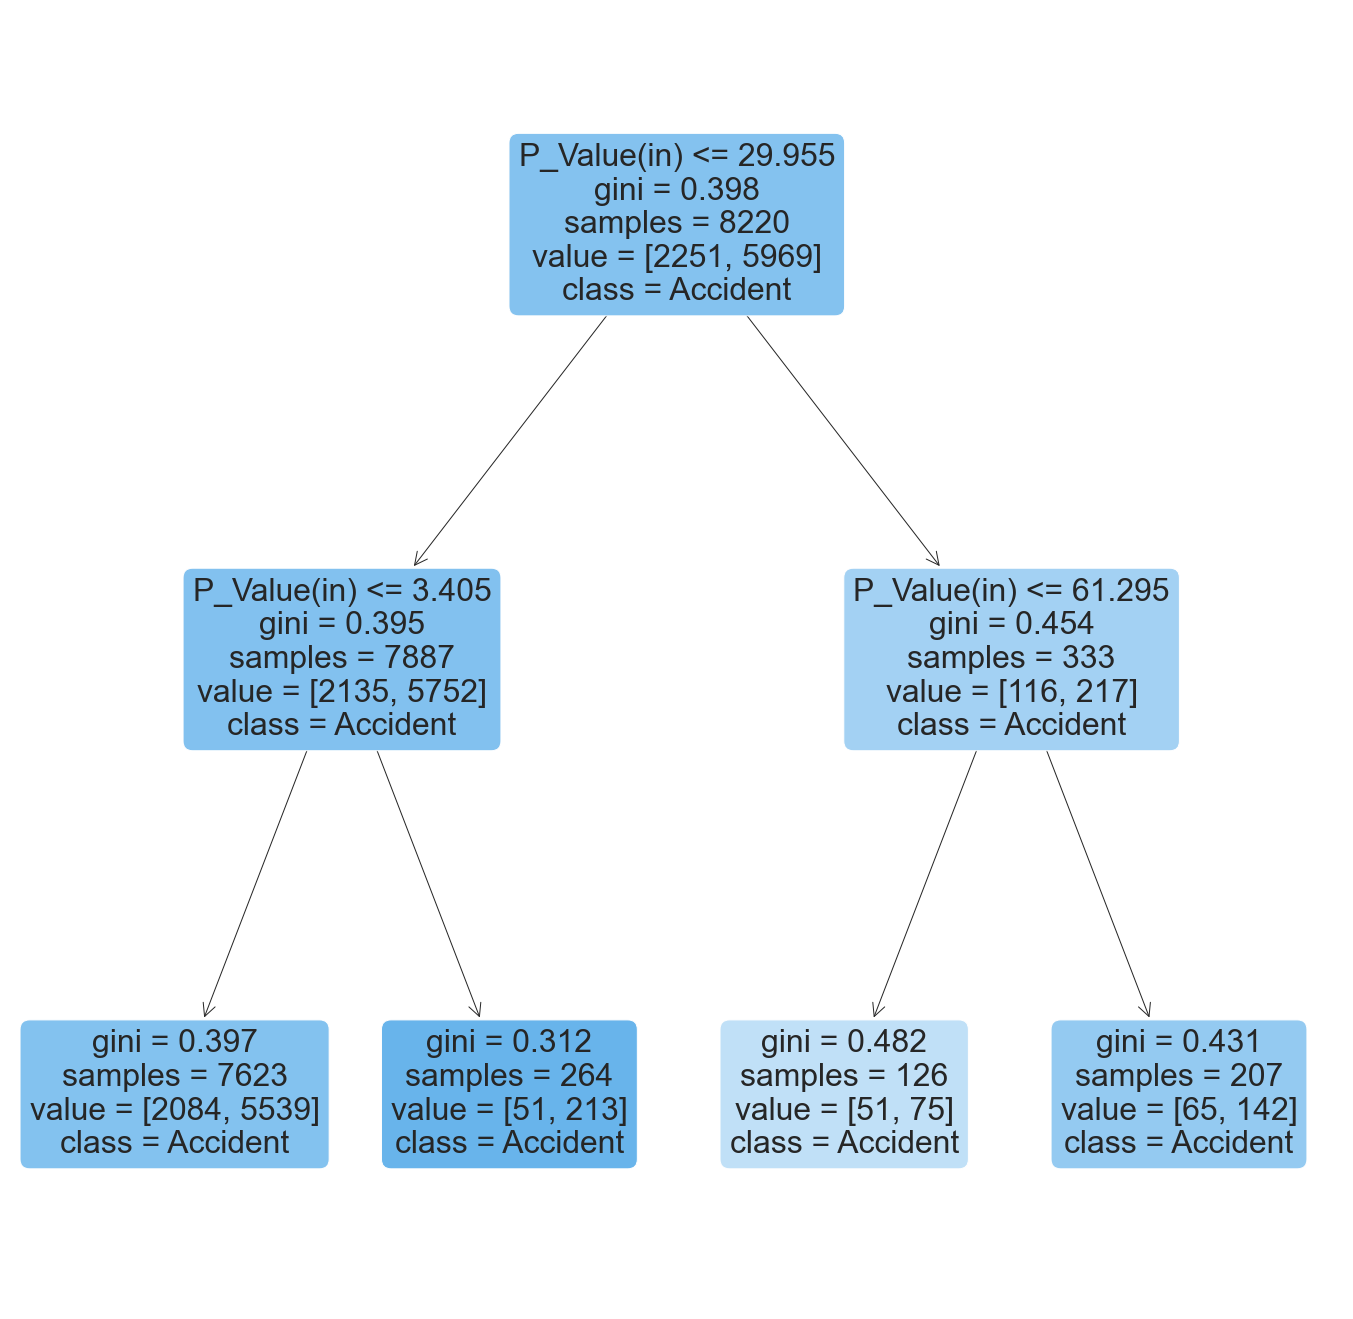

In [40]:
# Plot the trained Decision Tree
from sklearn.tree import plot_tree
accident = pd.DataFrame(data2['Accident'])  # Response
p_val = pd.DataFrame(data2['P_Value(in)'])  # Predictor
X_train, X_test, y_train, y_test = train_test_split(p_val, accident, test_size = 0.25)
dectree = DecisionTreeClassifier(max_depth = 2)  # create the decision tree object
dectree.fit(X_train, y_train)  # train the decision tree model
f = plt.figure(figsize=(24,24))
plot_tree(dectree, filled=True, rounded=True, feature_names=["P_Value(in)"], class_names=["No Accident","Accident"])

<AxesSubplot:xlabel='P_Value(in)', ylabel='Accident'>

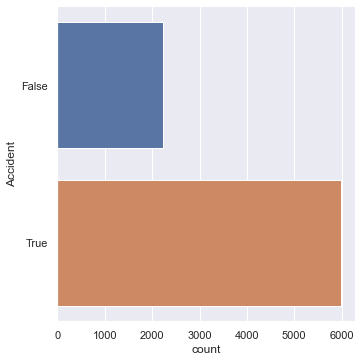

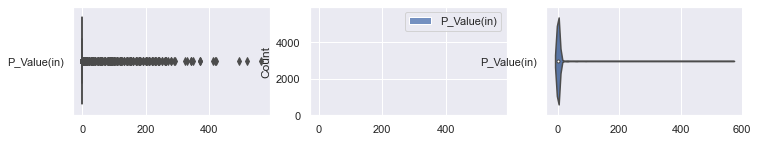

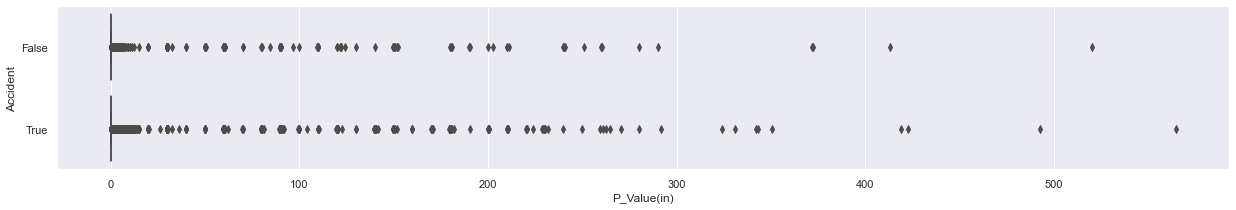

In [25]:
accident = pd.DataFrame(data2['Accident'])  # Response
p_val = pd.DataFrame(data2['P_Value(in)'])  # Predictor
X_train, X_test, y_train, y_test = train_test_split(p_val, accident, test_size = 0.25)
sb.catplot(y = "Accident", data = y_train, kind = "count")
f, axes = plt.subplots(1, 3, figsize=(12, 2))
sb.boxplot(data = X_train, orient = "h", ax = axes[0])
sb.histplot(data = X_train, ax = axes[1])
sb.violinplot(data = X_train, orient = "h", ax = axes[2])
trainDF = pd.concat([X_train, y_train], axis = 1).reindex(X_train.index)
f = plt.figure(figsize=(21, 3))
sb.boxplot(x = "P_Value(in)", y = "Accident", data = trainDF, orient = "h")

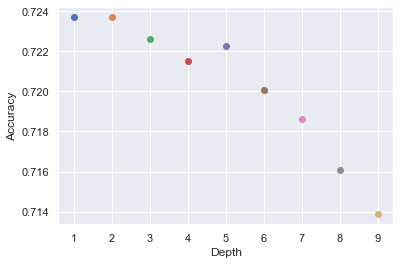

In [38]:
# List of values to try for max_depth:
max_depth_range = list(range(1, 10))
# List to store the accuracy for each value of max_depth:
accuracy = []
fig, ax = plt.subplots()
for depth in max_depth_range:
    clf = DecisionTreeClassifier(max_depth = depth, random_state = 0)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    accuracy.append(score)
    ax.plot(depth,score, marker='o',  linestyle = 'dotted', linewidth = 0.5)
    plt.xlabel('Depth')
    plt.ylabel('Accuracy')
    

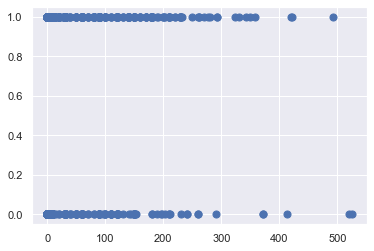